In [1]:
!pip install wordcloud

In [2]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re

from tqdm import tqdm
from matplotlib import pyplot as plt
from urllib.request import urlopen
from numpy.linalg import norm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
from fractions import Fraction

# default plot configurations 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

### Loading Data

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
        if i % 500000 == 0: print(i)
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
print("Start loading review data")
review_data = getDF(r'C:\Users\Xylon\Desktop\data200_grad\data\Toys_and_Games.json.gz')
print("Finish loading review data")

# total length of list, this number equals total number of products
print(len(review_data))

Start loading review data
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
6500000
7000000
7500000
8000000
Finish loading review data
8201231


### Data Preprocessing

Drop useless columns. 

In [5]:
review_data = review_data.drop(columns=['image', 'style'])

Technically, a user can only make 1 review at a reviewTime for a product. Therefore, we remove the duplicates which share the same reviewerID, product asin, and unixReviewTime.

In [6]:
review_data.drop_duplicates(subset=['reviewerID', 'asin', 'unixReviewTime'], inplace=True)

Fill in 0 and " " for NaN values in 'vote', 'reviewText', and 'summary'. Drop the remaining NaN values.

In [7]:
review_data['vote'] = review_data['vote'].str.replace(',', '').fillna(0).astype('int')

In [8]:
review_data['reviewText'] = review_data['reviewText'].fillna('')
review_data['summary'] = review_data['summary'].fillna('')

In [9]:
review_data = review_data.dropna()

In [10]:
print(len(review_data))

8002086


Convert "reviewTime" from string to datetime object. Extract year.

In [11]:
review_data = review_data[review_data.reviewTime.str.match(r"\d{2} \d{1,2}, \d{4}")]
review_data['reviewTime'] = pd.to_datetime(review_data['reviewTime'],format='%m %d, %Y', errors='coerce')
review_data['reviewYear'] = pd.DatetimeIndex(review_data['reviewTime']).year

Count the word-level length of "reviewText".

In [12]:
review_data['review_length'] = review_data['reviewText'].str.count(" ")+1

Convert numpy boolean to int (0 and 1) for the "verified" column.

In [13]:
review_data['verified'] = review_data['verified'].astype('int')

In [14]:
review_data.head(5)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,reviewYear,review_length
0,2.0,12,0,2016-09-22,A1IDMI31WEANAF,0020232233,Mackenzie Kent,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...,1474502400,2016,80
1,1.0,21,0,2016-09-18,A4BCEVVZ4Y3V3,0020232233,Jonathan Christian,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...,1474156800,2016,125
2,3.0,19,1,2016-09-12,A2EZ9PY1IHHBX0,0020232233,unpreparedtodie,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless",1473638400,2016,257
3,5.0,0,1,2017-03-02,A139PXTTC2LGHZ,0020232233,Ashley,Amazing buy! Bought it as a gift for our new d...,Five Stars,1488412800,2017,14
4,1.0,3,1,2017-02-08,A3IB33V29XIL8O,0020232233,Oghma_EM,As my review of GF9's previous screens these w...,Money trap,1486512000,2017,25


### Sentiment Analysis (Logistic Regression)
We want to investigate if logistic regression can make good predictions for ratings based on the review text. A rating of 3 is neutral and belongs to neither positive nor negative. Therefore, we remove the ratings of 3, and convert the reviews into binary according to the following rule: 1, 2 - negative. 4, 5 - positive.

In [15]:
df = review_data[review_data['overall'] != 3]
X = df['reviewText']
y = df['overall'].map({1:0, 2:0, 4:1, 5:1})

In [16]:
def text_fit(X, y, model, clf_model, coef_show=1, plot_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=42)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coef_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef}).sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coef_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coef_df.tail(20).to_string(index=False))
    if plot_show == 1:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr)
        plt.title("ROC curve")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")

#### Use CountVectorizer
We can see that the baseline accuracy using a CountVectorizer, which naively returns the frequency of words in the document is 85.63%. The accuracy of logistic regression improves a lot and reaches 94.55%. The ROC curve also indicates a good performance of logistic regression. However, if we look at the top 20 positive words and 20 negative words, we observe some meaning less tokens such as "luv", "excelent" (instead of "excellent"). We can improve this by using TfIdf.

In [17]:
c = CountVectorizer(stop_words = 'english')

In [18]:
text_fit(X, y, c, DummyClassifier(),0,0)

# features: 420760
# train records: 5556020
# test records: 1852007
Model Accuracy: 0.8563061586700266


# features: 420760
# train records: 5556020
# test records: 1852007


C:\Users\Xylon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9455299035046844

-Top 20 positive-
       Word  Coefficient
  excelente     5.880376
   excelent     5.469466
 pleasantly     5.028928
compliments     4.032347
  skeptical     3.858125
     awsome     3.647888
outstanding     3.556468
  priceless     3.370054
 flawlessly     3.187846
    prefect     3.182184
     superb     3.119728
   exceeded     3.088688
  excellent     3.067075
   hesitate     3.009346
     adores     2.947411
    coolest     2.924170
    exelent     2.881114
        luv     2.850476
  addictive     2.797654
      adore     2.786197

-Top 20 negative-
          Word  Coefficient
 disappointing    -3.054206
misrepresented    -3.074372
           wtf    -3.088349
   embarrassed    -3.167482
dissapointment    -3.173933
    displeased    -3.180035
    returnable    -3.184421
           pos    -3.265124
 dissappointed    -3.286471
      pathetic    -3.293621
     deceptive    -3.418943
 dissapointing    -3.535007
   unimpressed    -3.666687
   unsatis

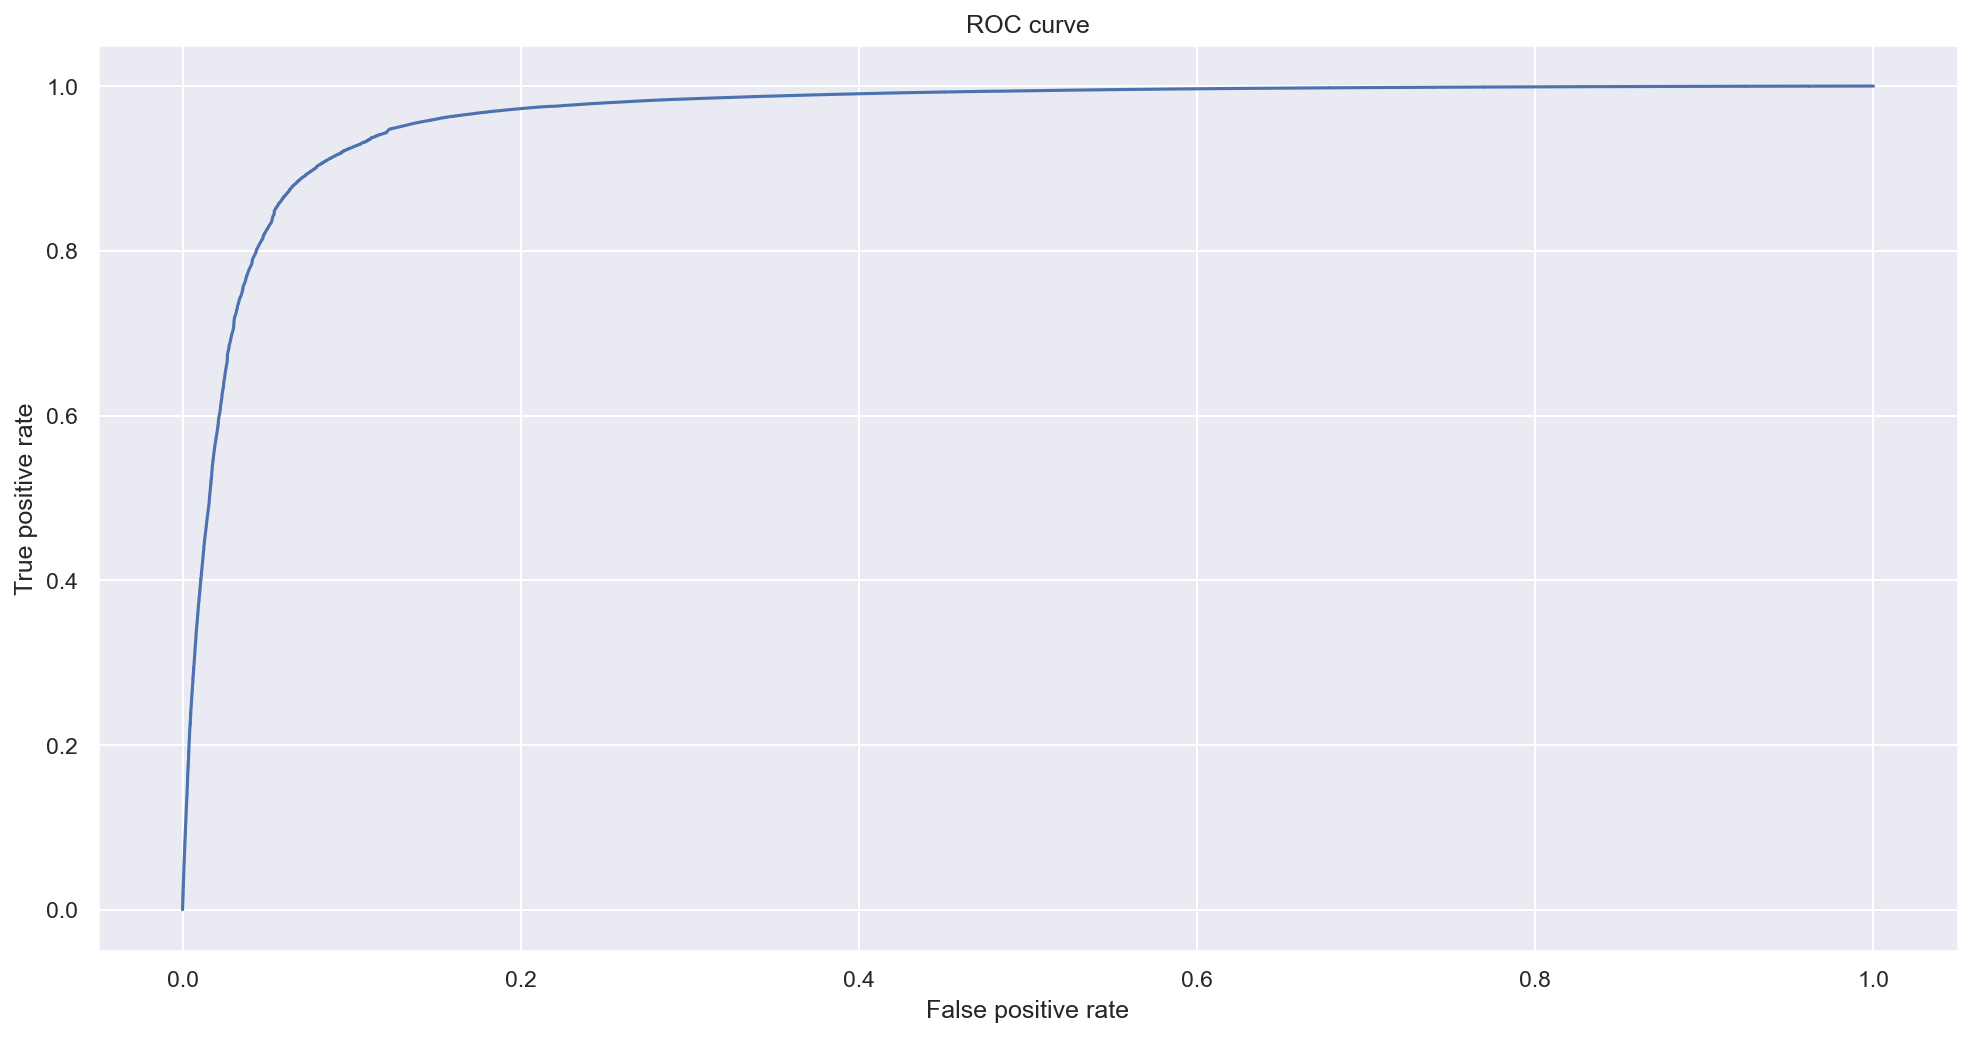

In [19]:
text_fit(X, y, c, LogisticRegression())

#### Use TfidfVectorizer
By using TfidfVectorizer, we can see that most word are meaningful and indicate a polarity of sentiment. The accuracy of logistic regresson also increase a bit to 94.95%. 

In [20]:
tfidf = TfidfVectorizer(stop_words = 'english')

# features: 420760
# train records: 5556020
# test records: 1852007


C:\Users\Xylon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9494553746287137

-Top 20 positive-
       Word  Coefficient
      loves    15.889839
    perfect    14.621646
      great    14.445012
       love    14.021232
  excellent    11.016036
    awesome    10.971371
   downside    10.693737
    amazing    10.205272
      loved    10.061049
 pleasantly     9.822440
  perfectly     9.312929
   favorite     8.949664
  complaint     8.674699
  fantastic     8.430501
   adorable     8.116654
      worry     8.068378
compliments     8.008448
     highly     7.922110
outstanding     7.874714
  hilarious     7.798976

-Top 20 negative-
          Word  Coefficient
        ripoff    -7.638079
          scam    -7.691165
       defeats    -7.999366
        return    -8.323457
      horrible    -8.763672
         broke    -8.838171
   embarrassed    -8.839420
       useless    -8.845347
  dissatisfied    -8.940215
      terrible    -9.124516
          junk    -9.133007
  unacceptable    -9.231476
         worst    -9.286020
          

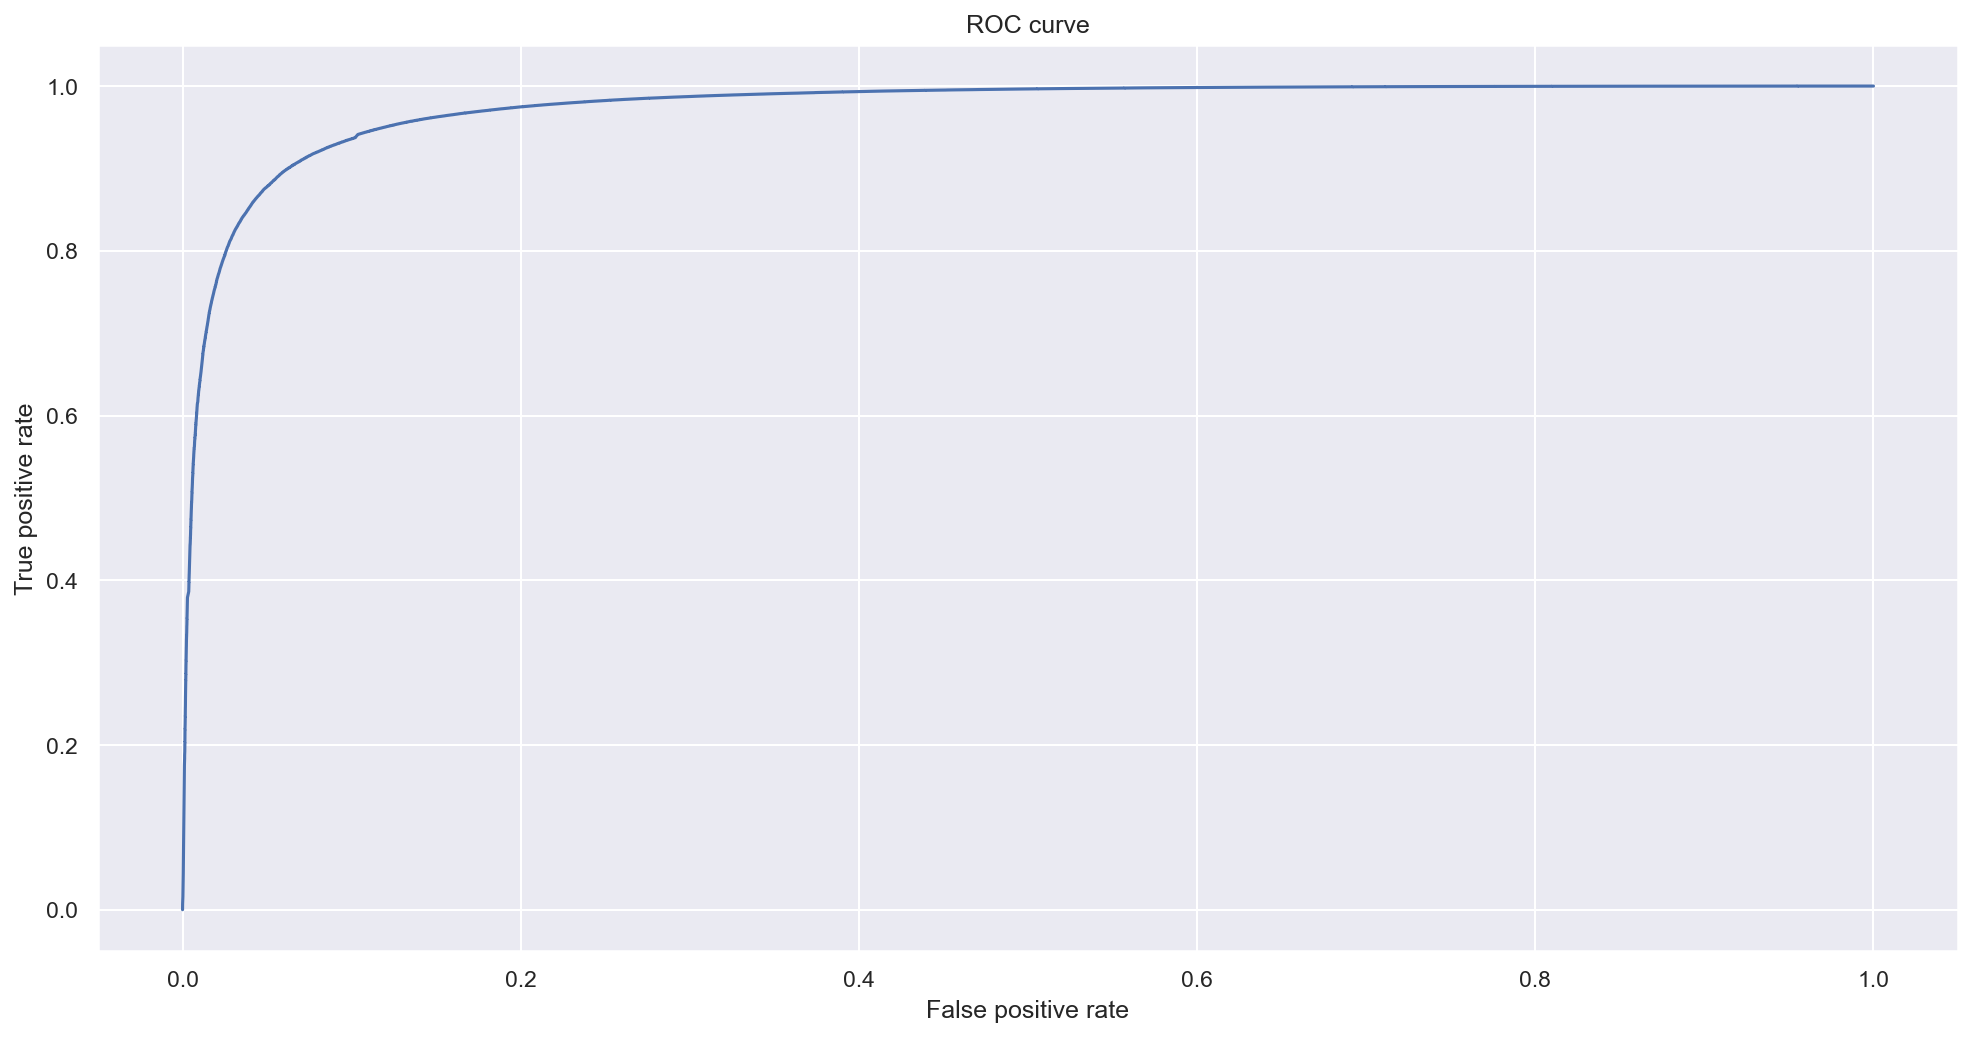

In [21]:
text_fit(X, y, tfidf, LogisticRegression())